In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import re
import zipfile
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path = '/content/drive/MyDrive/deep_fake.zip'
destination_directory = '/content/deep_fake'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# Print confirmation message
print("Unzipping complete!")

import random
dataset_dir = '/content/deep_fake/Dataset/Train/Real'
folder = dataset_dir

random_img_path = os.path.join(folder, random.choice(os.listdir(folder)))
print("Random image size before preprocessing:", Image.open(random_img_path).size)

Unzipping complete!
Random image size before preprocessing: (256, 256)


In [5]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root="/content/deep_fake/Dataset/Train", transform=data_transform)


In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values (0 or 1)
encoded_labels = label_encoder.fit_transform(dataset.classes)

# Print the encoded labels
print(encoded_labels)

[0 1]


In [7]:
from torch.utils.data import Subset

# Separate samples by class
real_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Real"]
fake_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Fake"]

# Randomly sample 20,000 samples from each class
real_samples = np.random.choice(real_samples, 25000, replace=False)
fake_samples = np.random.choice(fake_samples, 25000, replace=False)

# Combine the sampled indices
filtered_indices = np.concatenate([real_samples, fake_samples])
filtered_samples = [dataset.samples[idx] for idx in filtered_indices]

# Create a Subset dataset using the filtered samples
filtered_dataset = Subset(dataset, filtered_indices)

dataset = filtered_dataset
# Define sizes for train, validation, and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
vali_size = int(0.11112*len(train_set))
train_size = len(train_set) - vali_size
train_set, vali_set = torch.utils.data.random_split(train_set, [train_size, vali_size])

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [9]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model_name = 'vit_base_patch16_224'  # You can choose a different model
model = timm.create_model(model_name, pretrained=True, num_classes = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [14]:
from tqdm import tqdm

def train_and_validate(model, train_loader, vali_loader, optimizer, loss_fn, device, num_epochs=10, early_stopping=None):
    train_loss, train_accuracy, validation_loss, validation_accuracy = [], [], [], []
    best_val_accuracy = 0
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()
        running_train_loss, running_train_correct, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss.append(running_train_loss / len(train_loader))
        train_accuracy.append(running_train_correct / total_train)

        # Validation
        model.eval()
        running_val_loss, running_val_correct, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(vali_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                running_val_correct += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss_epoch = running_val_loss / len(vali_loader)
        val_acc_epoch = running_val_correct / total_val
        validation_loss.append(val_loss_epoch)
        validation_accuracy.append(val_acc_epoch)

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Loss: {validation_loss[-1]:.4f}, Accuracy: {validation_accuracy[-1]:.4f}")

        # Check if validation accuracy has improved
        if val_acc_epoch > best_val_accuracy:
            best_val_accuracy = val_acc_epoch
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Check for early stopping
        if early_stopping and epochs_no_improve >= early_stopping:
            print(f'Early stopping triggered after {epochs_no_improve} epochs without improvement')
            early_stop = True
            break

    if not early_stop:
        print('Training completed without early stopping.')

    return train_loss, train_accuracy, validation_loss, validation_accuracy

In [17]:
# Train and validate the model
train_loss, train_accuracy, val_loss, val_accuracy = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    num_epochs=10
)

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.63it/s]


Epoch 1/10
Training Loss: 0.5880, Accuracy: 0.6795
Validation Loss: 0.5041, Accuracy: 0.7508


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.64it/s]


Epoch 2/10
Training Loss: 0.4891, Accuracy: 0.7658
Validation Loss: 0.4496, Accuracy: 0.7868


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 3/10
Training Loss: 0.4527, Accuracy: 0.7874
Validation Loss: 0.4702, Accuracy: 0.7820


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 4/10
Training Loss: 0.4170, Accuracy: 0.8082
Validation Loss: 0.4205, Accuracy: 0.8026


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.63it/s]


Epoch 5/10
Training Loss: 0.3974, Accuracy: 0.8173
Validation Loss: 0.3996, Accuracy: 0.8192


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.64it/s]


Epoch 6/10
Training Loss: 0.3752, Accuracy: 0.8309
Validation Loss: 0.4027, Accuracy: 0.8104


Epoch 7/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 7/10
Training Loss: 0.3545, Accuracy: 0.8413
Validation Loss: 0.3653, Accuracy: 0.8326


Epoch 8/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 8/10
Training Loss: 0.3366, Accuracy: 0.8523
Validation Loss: 0.3489, Accuracy: 0.8470


Epoch 9/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 9/10
Training Loss: 0.3151, Accuracy: 0.8624
Validation Loss: 0.3540, Accuracy: 0.8466


Epoch 10/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 10/10
Training Loss: 0.3051, Accuracy: 0.8667
Validation Loss: 0.3465, Accuracy: 0.8520
Training completed without early stopping.


In [18]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def test_model(model, test_loader, loss_fn, device):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

    all_predictions = []
    all_true_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating test data"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = (np.array(all_predictions) == np.array(all_true_labels)).mean() * 100

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_true_labels, all_predictions

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

def report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred):
    # Report results
    print(f"Training Accuracy: {np.mean(train_accuracy):.2f}%")
    print(f"Training Loss: {np.mean(train_loss):.4f}")
    print(f"Validation Accuracy: {np.mean(val_accuracy):.2f}%")
    print(f"Validation Loss: {np.mean(val_loss):.4f}")
    print(f"Testing Accuracy: {test_accuracy:.2f}%")
    print(f"Testing Loss: {test_loss:.4f}")

    # Plot accuracy over time
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss over time
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [20]:
test_loss, test_accuracy, y_true, y_pred = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    device=device
)

Evaluating test data: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]

Test Loss: 0.3444
Test Accuracy: 84.68%


Training Accuracy: 0.81%
Training Loss: 0.4031
Validation Accuracy: 0.81%
Validation Loss: 0.4061
Testing Accuracy: 84.68%
Testing Loss: 0.3444


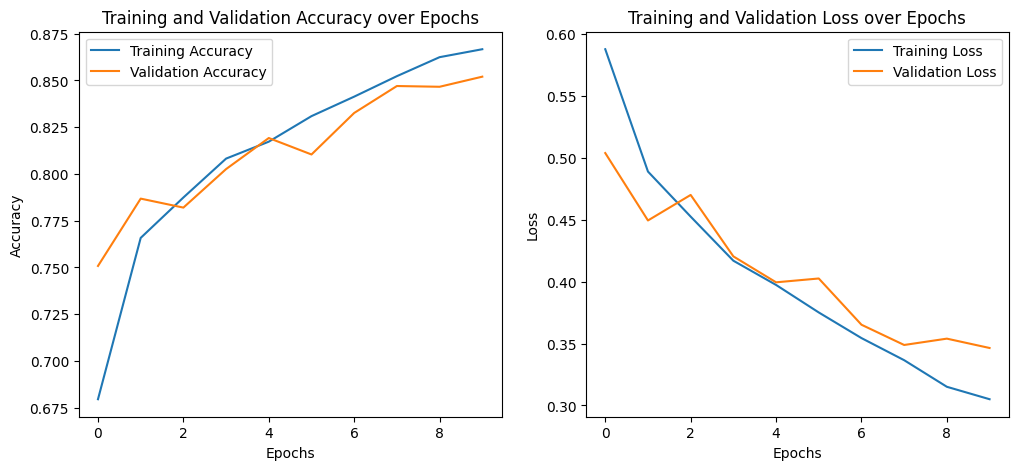

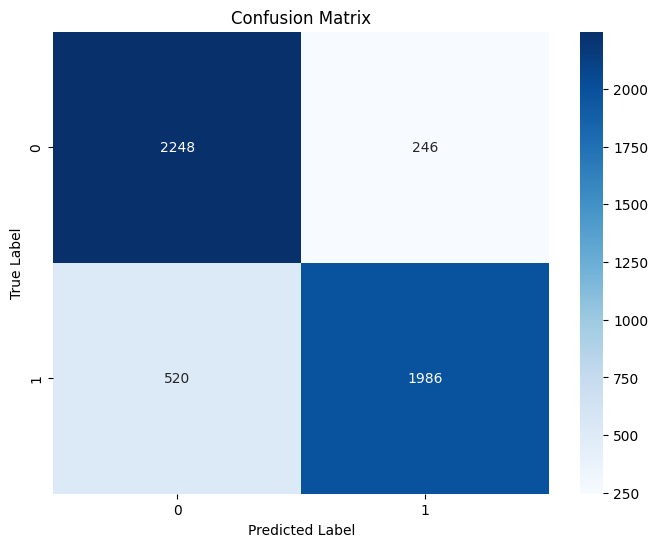

In [21]:
report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred)

Early Stopping

In [22]:
# Train and validate the model
train_loss, train_accuracy, val_loss, val_accuracy = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    num_epochs=10,
    early_stopping=5
)

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:58<00:00,  2.66it/s]


Epoch 1/10
Training Loss: 0.2784, Accuracy: 0.8803
Validation Loss: 0.3176, Accuracy: 0.8606


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 2/10
Training Loss: 0.2648, Accuracy: 0.8861
Validation Loss: 0.3173, Accuracy: 0.8648


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 3/10
Training Loss: 0.2493, Accuracy: 0.8940
Validation Loss: 0.2968, Accuracy: 0.8730


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.66it/s]


Epoch 4/10
Training Loss: 0.2379, Accuracy: 0.9000
Validation Loss: 0.3332, Accuracy: 0.8582


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


Epoch 5/10
Training Loss: 0.2226, Accuracy: 0.9046
Validation Loss: 0.3167, Accuracy: 0.8664


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.66it/s]


Epoch 6/10
Training Loss: 0.2086, Accuracy: 0.9133
Validation Loss: 0.3094, Accuracy: 0.8718


Epoch 7/10 - Validation: 100%|██████████| 157/157 [00:58<00:00,  2.67it/s]


Epoch 7/10
Training Loss: 0.1904, Accuracy: 0.9204
Validation Loss: 0.3216, Accuracy: 0.8746


Epoch 8/10 - Validation: 100%|██████████| 157/157 [00:59<00:00,  2.66it/s]


Epoch 8/10
Training Loss: 0.1788, Accuracy: 0.9255
Validation Loss: 0.2835, Accuracy: 0.8792


Epoch 9/10 - Validation: 100%|██████████| 157/157 [00:58<00:00,  2.66it/s]


Epoch 9/10
Training Loss: 0.1629, Accuracy: 0.9317
Validation Loss: 0.3351, Accuracy: 0.8676


Epoch 10/10 - Validation: 100%|██████████| 157/157 [00:58<00:00,  2.67it/s]

Epoch 10/10
Training Loss: 0.1520, Accuracy: 0.9381
Validation Loss: 0.3596, Accuracy: 0.8710
Training completed without early stopping.


In [23]:
test_loss, test_accuracy, y_true, y_pred = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    device=device
)

Evaluating test data: 100%|██████████| 157/157 [00:59<00:00,  2.66it/s]

Test Loss: 0.2855
Test Accuracy: 88.28%


Training Accuracy: 0.91%
Training Loss: 0.2146
Validation Accuracy: 0.87%
Validation Loss: 0.3191
Testing Accuracy: 88.28%
Testing Loss: 0.2855


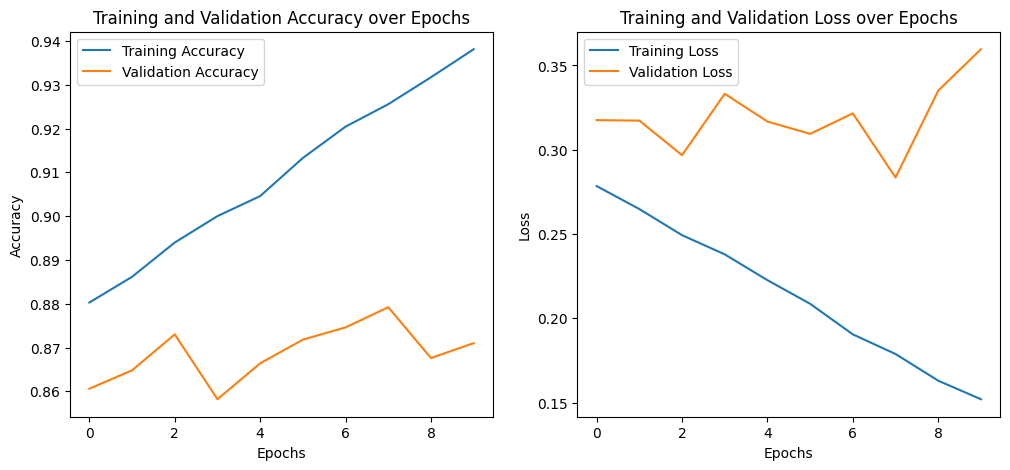

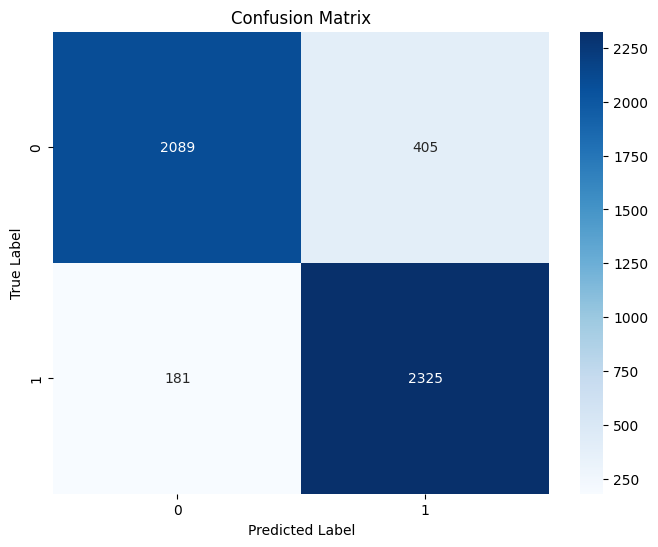

In [24]:
report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred)